<a href="https://colab.research.google.com/github/t-ito-takumi/corabo_test/blob/master/my_meet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


画像データのダウンロード

In [0]:
!wget https://www.dropbox.com/s/ex2vbaiefxeq7ks/data.zip

--2019-10-06 02:22:56--  https://www.dropbox.com/s/ex2vbaiefxeq7ks/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ex2vbaiefxeq7ks/data.zip [following]
--2019-10-06 02:22:56--  https://www.dropbox.com/s/raw/ex2vbaiefxeq7ks/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca1d32061c03e83788838102d3d.dl.dropboxusercontent.com/cd/0/inline/Ap7FraSQG56d0emdQKhp_2J15JrK1KJ8igMfukn9RS_jqiyXWJE9zGrqowG8Fqqgv4nxBWFm9eE2X4XMJ1rRZTfBoH2Y_6WsNCubnURsjCd2IA/file# [following]
--2019-10-06 02:22:56--  https://uca1d32061c03e83788838102d3d.dl.dropboxusercontent.com/cd/0/inline/Ap7FraSQG56d0emdQKhp_2J15JrK1KJ8igMfukn9RS_jqiyXWJE9zGrqowG8Fqqgv4nxBWFm9eE2X4XMJ1rRZTfBoH2Y_6WsNCubnURsjCd2IA/file
Resolving uca1d32061c03e8378883

圧縮ファイルを解凍

In [0]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/test/
   creating: data/test/curry/
  inflating: data/test/curry/curry13.jpg  
  inflating: data/test/curry/curry07.jpg  
  inflating: data/test/curry/curry06.jpg  
  inflating: data/test/curry/curry12.jpg  
  inflating: data/test/curry/curry04.jpg  
  inflating: data/test/curry/curry10.jpg  
  inflating: data/test/curry/curry11.jpg  
  inflating: data/test/curry/curry05.jpg  
  inflating: data/test/curry/curry01.jpg  
  inflating: data/test/curry/curry15.jpg  
  inflating: data/test/curry/curry14.jpg  
  inflating: data/test/curry/curry16.jpg  
  inflating: data/test/curry/curry02.jpg  
  inflating: data/test/curry/curry03.jpg  
  inflating: data/test/curry/curry17.jpg  
  inflating: data/test/curry/curry19.jpg  
  inflating: data/test/curry/curry18.jpg  
  inflating: data/test/curry/curry08.jpg  
  inflating: data/test/curry/curry20.jpg  
  inflating: data/test/curry/curry21.jpg  
  inflating: data/test/curry/curry09.jpg  
  inf

学習

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
import numpy as np

# 乱数固定 ----------
import keras.backend as K
import tensorflow as tf

np.random.seed(seed=0)

session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1)

tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# 画像ファイルパス ----------
train_data_dir = "data/train/" # training dir path
validation_data_dir = "data/validation/" # validation dir path

# モデル条件設定 ----------
img_width, img_height = 150, 150 # モデル画像サイズ
nb_train_samples = 1800 # training data (90x20)
nb_validation_samples = 200 # validation data (10x20)
epochs = 10 # エポック数
batch_size = 64 # バッチ数
nb_category = 2 # カテゴリ数（curry, meat）

# 画像データのジェネレータ ----------


save_path = 'output'  # 保存ディレクトリのパス
# 指定したディレクトリが存在しないとエラーになるので、
# 予め作成しておく。
import os
os.makedirs(save_path, exist_ok=True)

# 訓練用
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.3,
    rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        save_prefix='generated',
        save_to_dir=save_path,
        save_format='jpg',
        class_mode="categorical")
# 検証用
validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode="categorical")

# モデル定義 ----------
# モデルVGG16（not include Top）
input_tensor = Input(shape=(img_width, img_height, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# モデル
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
top_model.add(BatchNormalization())
top_model.add(Dropout(0.5))
top_model.add(Dense(nb_category, activation='softmax'))

model = Model(inputs=vgg16.input, outputs=top_model(vgg16.output))

# layer14までの重みを固定
for layer in model.layers[:15]:
    layer.trainable = False

# コールバック

# early_stopping_cb = EarlyStopping(
#    monitor='val_acc', patience=10, verbose=1, mode='max')

# checkpoint_cb = ModelCheckpoint(
#    './{epoch:03d}-{val_acc:.5f}.hdf5', save_best_only=True)

csvlogger_cb = CSVLogger('./history.csv') 

# コンパイル ----------
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.rmsprop(lr=5e-7, decay=5e-5),
              metrics=['accuracy'])

model.summary()


# 学習の実行

history = model.fit_generator(
      train_generator,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size,
      callbacks=[csvlogger_cb])

# モデルを保存
model.save("model.h5")

Found 183 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
____________________________________________

学習のログを表示

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

history = pd.read_csv('history.csv')
history_rows = len(history)

# accuracy
plt.plot(range(1, history_rows + 1), history['acc']) # training
plt.plot(range(1, history_rows + 1), history['val_acc']) # validation
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

# loss
plt.plot(range(1, history_rows + 1), history['loss'])
plt.plot(range(1, history_rows + 1), history['val_loss'])
plt.title('model accuracy')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [0]:
from keras.models import load_model
model = load_model("./model.h5")
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from keras.models import Model, Sequential, load_model
import pandas as pd
import numpy as np
import os
import glob

# テストデータで推論
test_data_dir = "data/test/" # テスト用データdir
img_width, img_height = 150, 150 # 画像サイズ
test_files = sorted(glob.glob(os.path.join(test_data_dir, '*', '*.jpg')))
nb_test_samples = len(test_files) # 画像データ数
batch_size = 1 # バッチサイズ
nb_category = 2 # カテゴリ数（curry, meat）

# 画像データのジェネレータ（テスト用）
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

# 分類予測
pred = model.predict_generator(
        test_generator,
        steps=len(test_files),
        verbose=1)


Found 44 images belonging to 2 classes.
44/44 [==============================] - 2s 35ms/step


In [0]:
labels = ['curry', 'meat']
# データ0～21 -> curry画像
# デー22～44 -> meat画像

fail = 0

print("*** test data [curry] *****")
for i in pred[0:22]:
    cls = np.argmax(i)
    score = np.max(i)
    if labels[cls] != "curry":
        fail += 1
    print("pred: {}  score = {:.3f}".format(labels[cls], score))

print("-" * 30)

print("*** test data [meat] *****")
for i in pred[22:44]:
    cls = np.argmax(i)
    score = np.max(i)
    if labels[cls] != "meat":
        fail += 1
    print("pred: {}  score = {:.3f}".format(labels[cls], score))

print("accuracy = {:.4f}".format(1-fail/len(pred)))

*** test data [curry] *****
pred: curry  score = 0.860
pred: meat  score = 0.995
pred: curry  score = 0.929
pred: curry  score = 0.655
pred: curry  score = 0.889
pred: curry  score = 0.980
pred: curry  score = 0.736
pred: curry  score = 0.841
pred: curry  score = 0.571
pred: curry  score = 0.890
pred: curry  score = 0.840
pred: curry  score = 0.527
pred: curry  score = 0.670
pred: meat  score = 0.880
pred: curry  score = 0.757
pred: curry  score = 0.836
pred: curry  score = 0.958
pred: curry  score = 0.581
pred: meat  score = 0.943
pred: curry  score = 0.911
pred: curry  score = 0.810
pred: curry  score = 0.538
------------------------------
*** test data [meat] *****
pred: curry  score = 0.662
pred: meat  score = 0.969
pred: meat  score = 0.741
pred: meat  score = 0.978
pred: meat  score = 0.975
pred: meat  score = 0.996
pred: meat  score = 0.793
pred: meat  score = 0.829
pred: curry  score = 0.915
pred: meat  score = 0.958
pred: meat  score = 0.876
pred: meat  score = 0.934
pred: mea

In [0]:
import pandas as pd
import numpy as np
import cv2
from keras import backend as K
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import load_model

K.set_learning_phase(1)

def Grad_Cam(input_model, x, layer_name):
    # 前処理
    X = np.expand_dims(x, axis=0)
    X = X.astype('float32')
    preprocessed_input = X / 255.0

    # 予測クラス算出
    predictions = model.predict(preprocessed_input)
    class_idx = np.argmax(predictions[0])
    class_output = model.output[:, class_idx]

    #  勾配取得
    conv_output = model.get_layer(layer_name).output
    grads = K.gradients(class_output, conv_output)[0]
    gradient_function = K.function([model.input], [conv_output, grads])
    output, grads_val = gradient_function([preprocessed_input])
    output, grads_val = output[0], grads_val[0]

    # 重み平均化、cam算出
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)

    # ヒートマップ合成
    w = x.shape[0]
    h = x.shape[1]
    cam = cv2.resize(cam, (w, h), cv2.INTER_LINEAR)
    
    cam = np.maximum(cam, 0)
    if cam.max() == 0: # 色付け不可（ブルー画像になる）
      return None
    
    cam = cam / cam.max()

    jetcam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)
    jetcam = (np.float32(jetcam) + x / 2)

    return jetcam



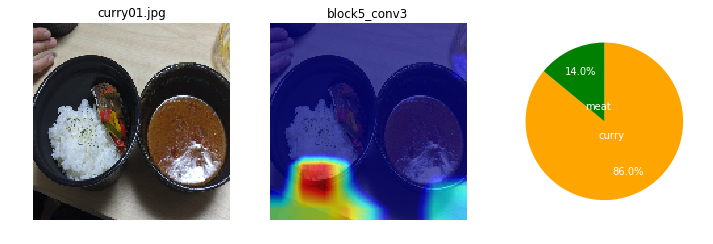

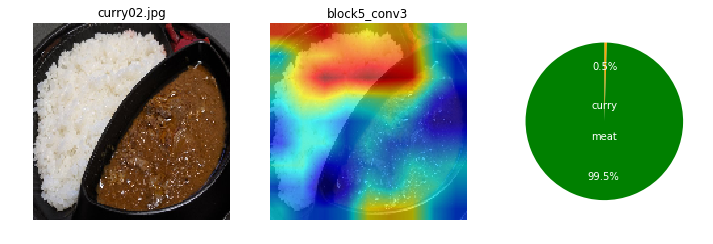

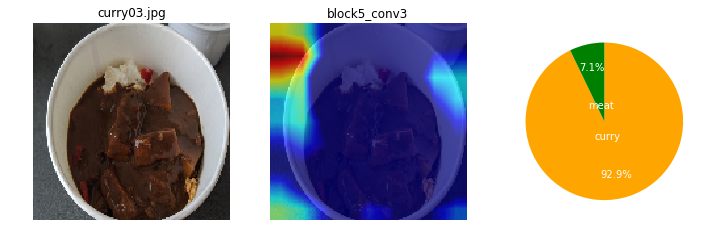

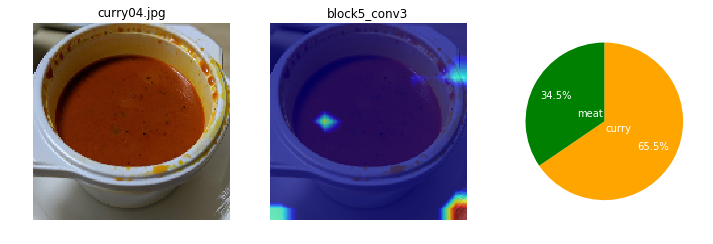

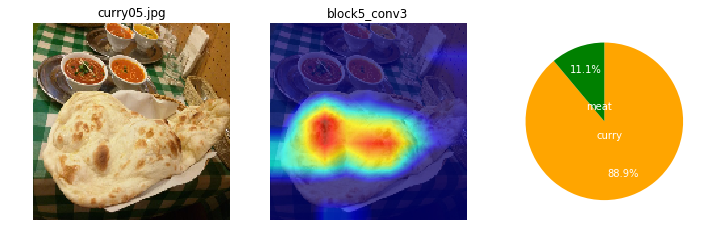

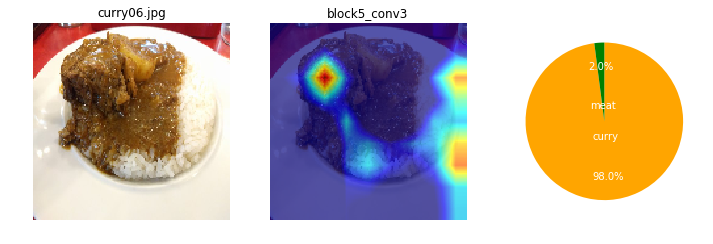

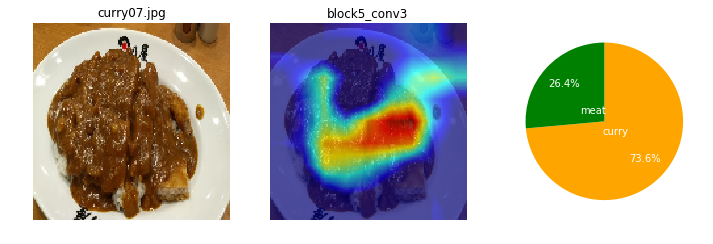

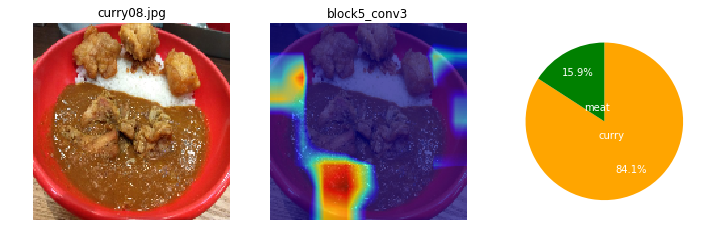

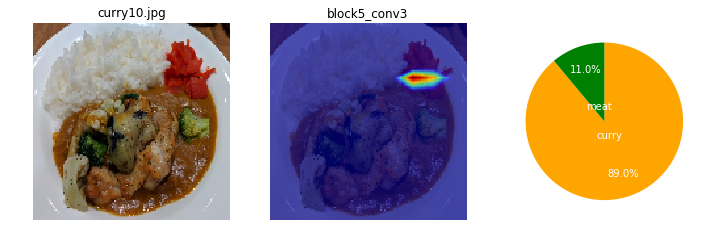

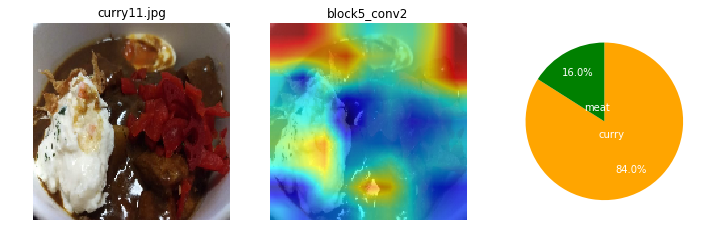

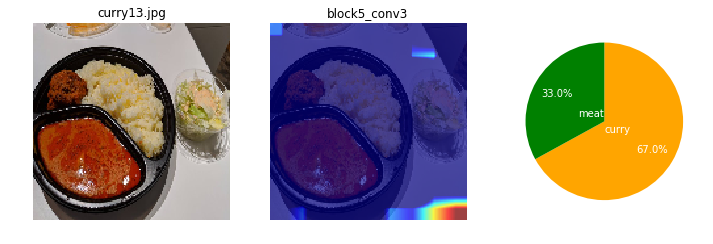

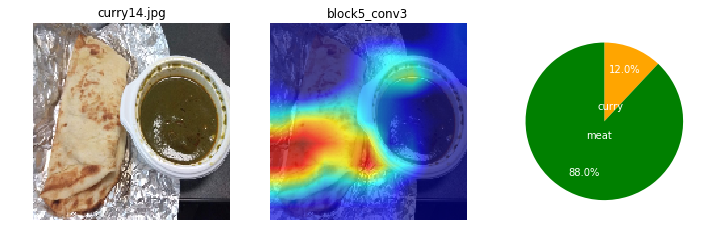

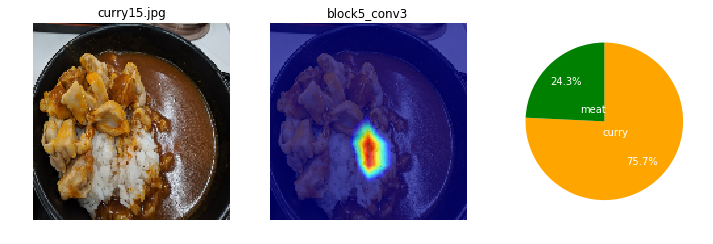

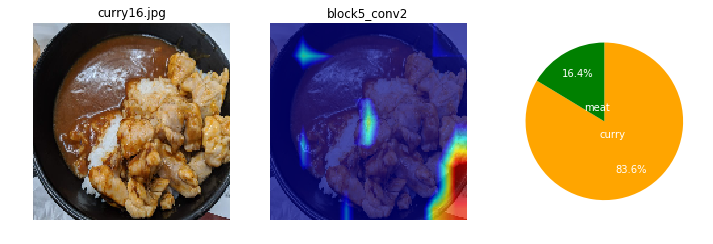

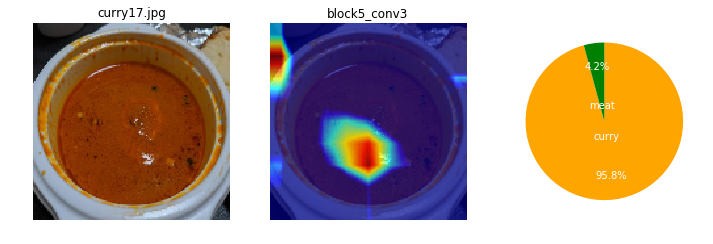

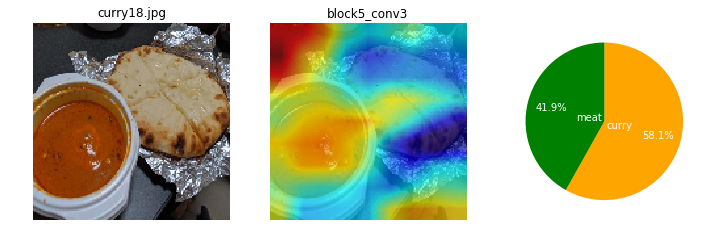

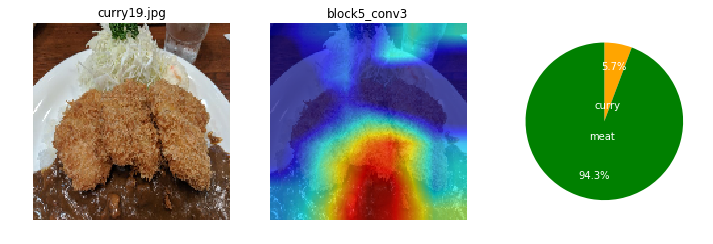

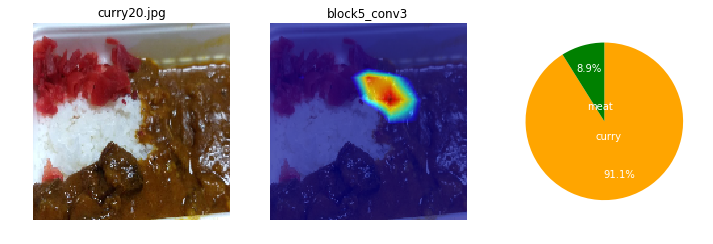

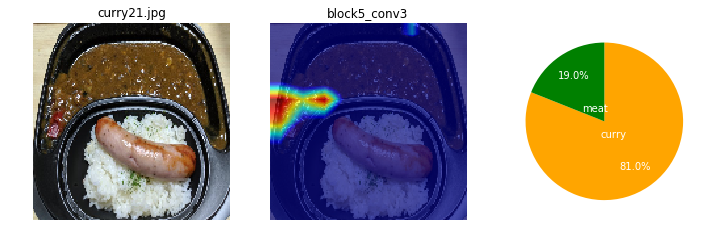

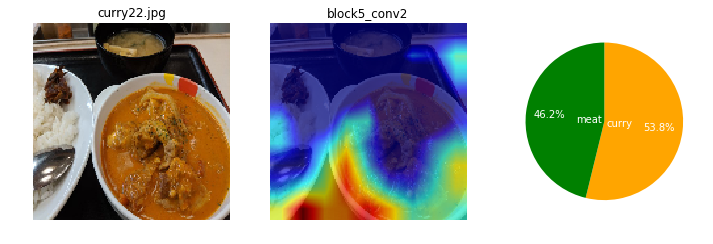

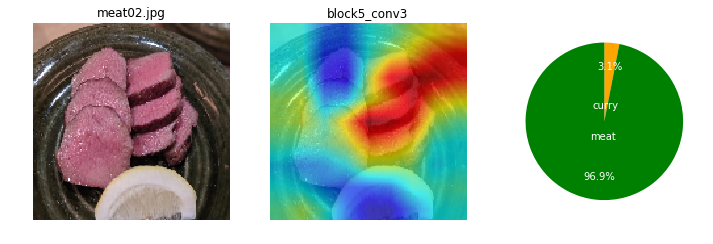

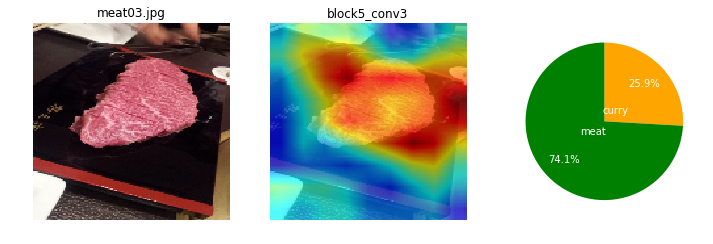

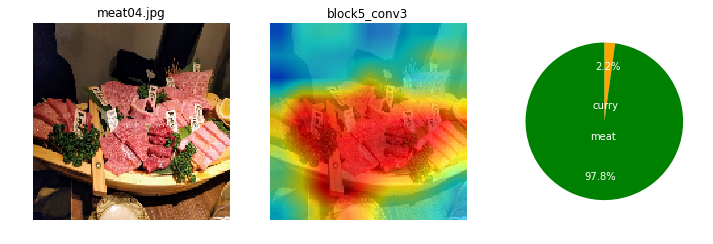

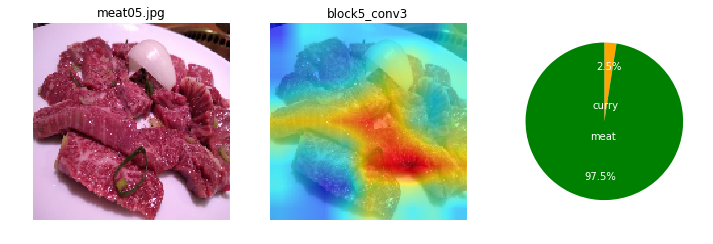

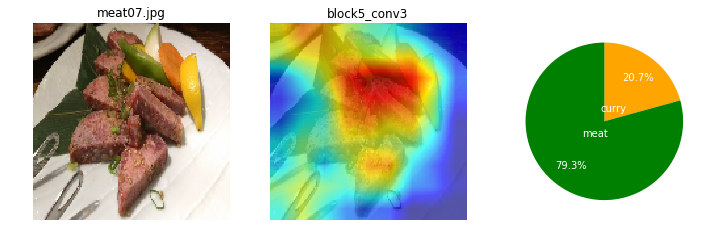

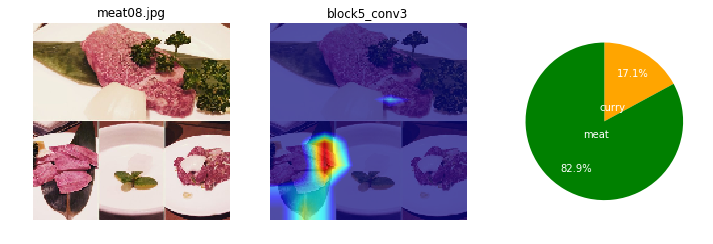

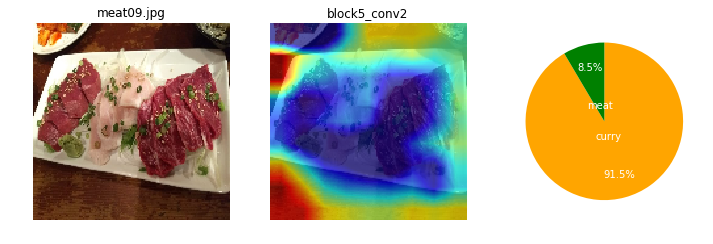

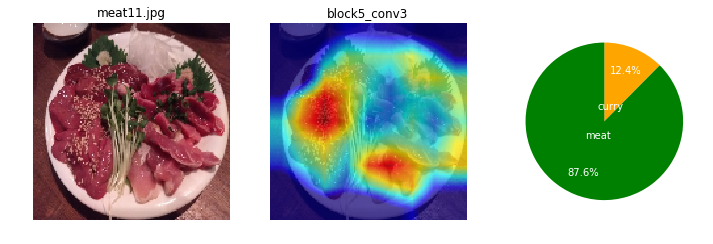

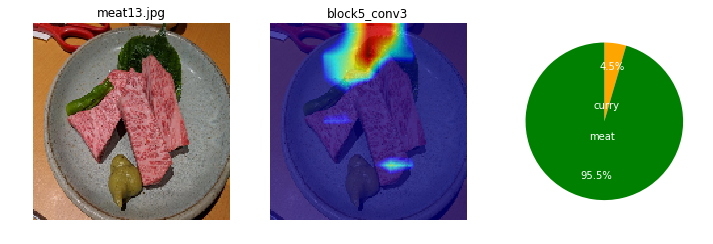

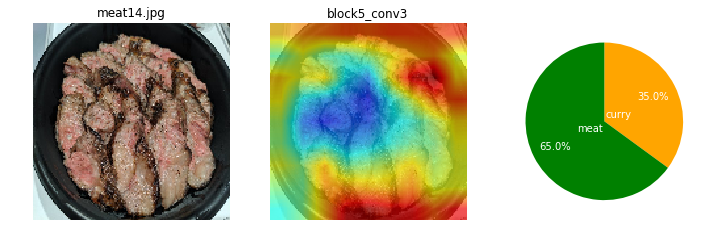

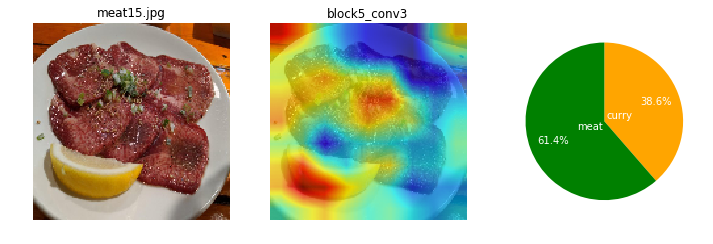

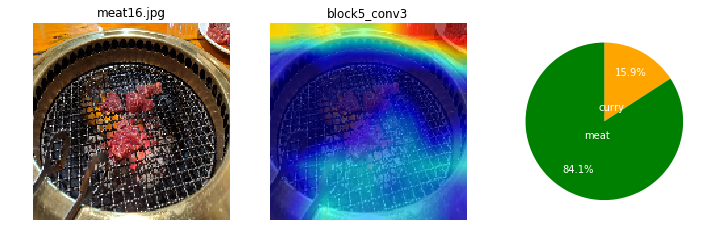

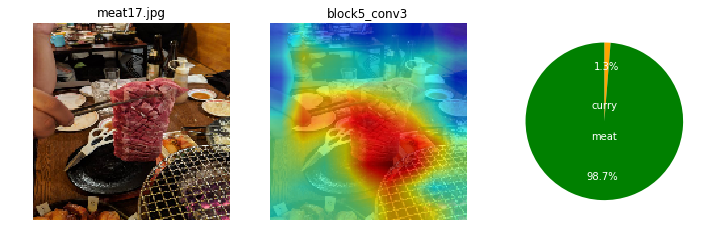

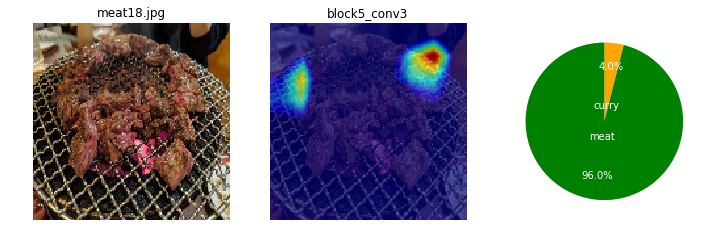

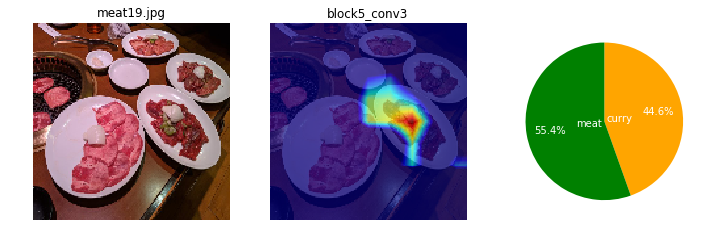

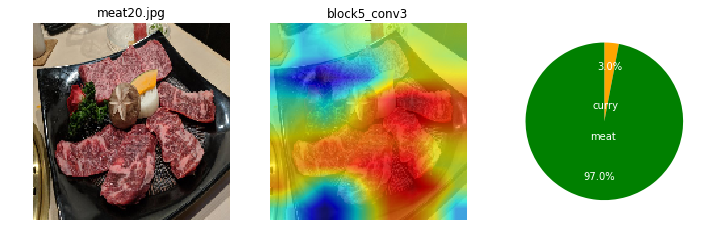

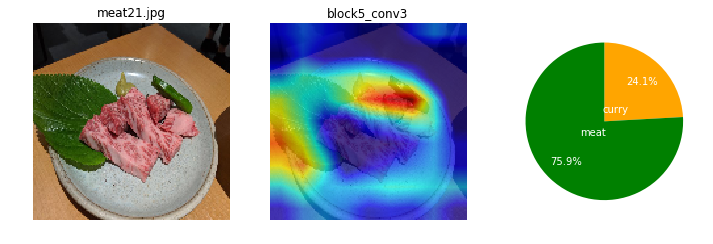

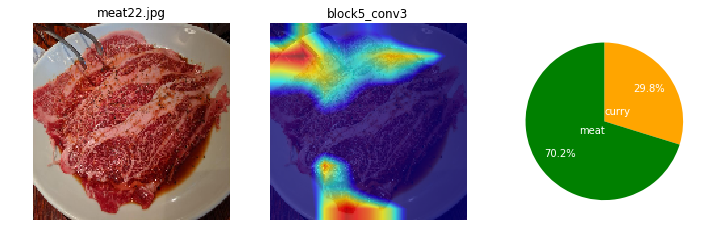

In [0]:
import os
import glob
import matplotlib.pyplot as plt

labels = ['curry', 'meat']
test_dir = 'data/test' # テスト画像dir

test_files = sorted(glob.glob(os.path.join(test_dir, '*', '*.jpg')))

test_data_count = len(test_files)

for idx in range(test_data_count):
    
    file = test_files[idx] # file path
    file_name = os.path.basename(file)
    img_original = load_img(file, target_size=(150,150))

    # grad cam
    arr = img_to_array(img_original)
    layer_name = 'block5_conv3' # 最後の畳み込み層
    grad_cam = Grad_Cam(model, arr, layer_name) # grad_cam呼び出し
    
    if grad_cam is None:
        layer_name = 'block5_conv2' # 最後のひとつ前の畳み込み層（ラストがダメな場合）
        grad_cam = Grad_Cam(model, arr, layer_name)   
    img_grad_cam = array_to_img(grad_cam)

    # 画像表示
    fig = plt.figure(figsize=(12, 4))

    # Image Original 
    fig.add_subplot(1, 3, 1)
    plt.imshow(img_original)
    plt.title(file_name)
    plt.axis('off')

    # Image Grad-Cam
    fig.add_subplot(1, 3, 2)
    plt.imshow(img_grad_cam)
    plt.title(layer_name)
    plt.axis('off')

    # Pie Graph prediction score
    data_pred = pred[idx]

    colors = ["orange", "green"] # pred dog

    fig.add_subplot(1, 3, 3)
    plt.pie(data_pred,
            labels=labels,
            colors=colors,
            counterclock=False,
            startangle=90,
            labeldistance=0.2,
            autopct="%.1f%%",
            pctdistance=0.7,
            textprops={'color': 'white', 'horizontalalignment':'center'})

    plt.show()